<a href="https://colab.research.google.com/github/jack-tuna/Jupyter-Workings/blob/master/02_NExUS_DR_2022_ML_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

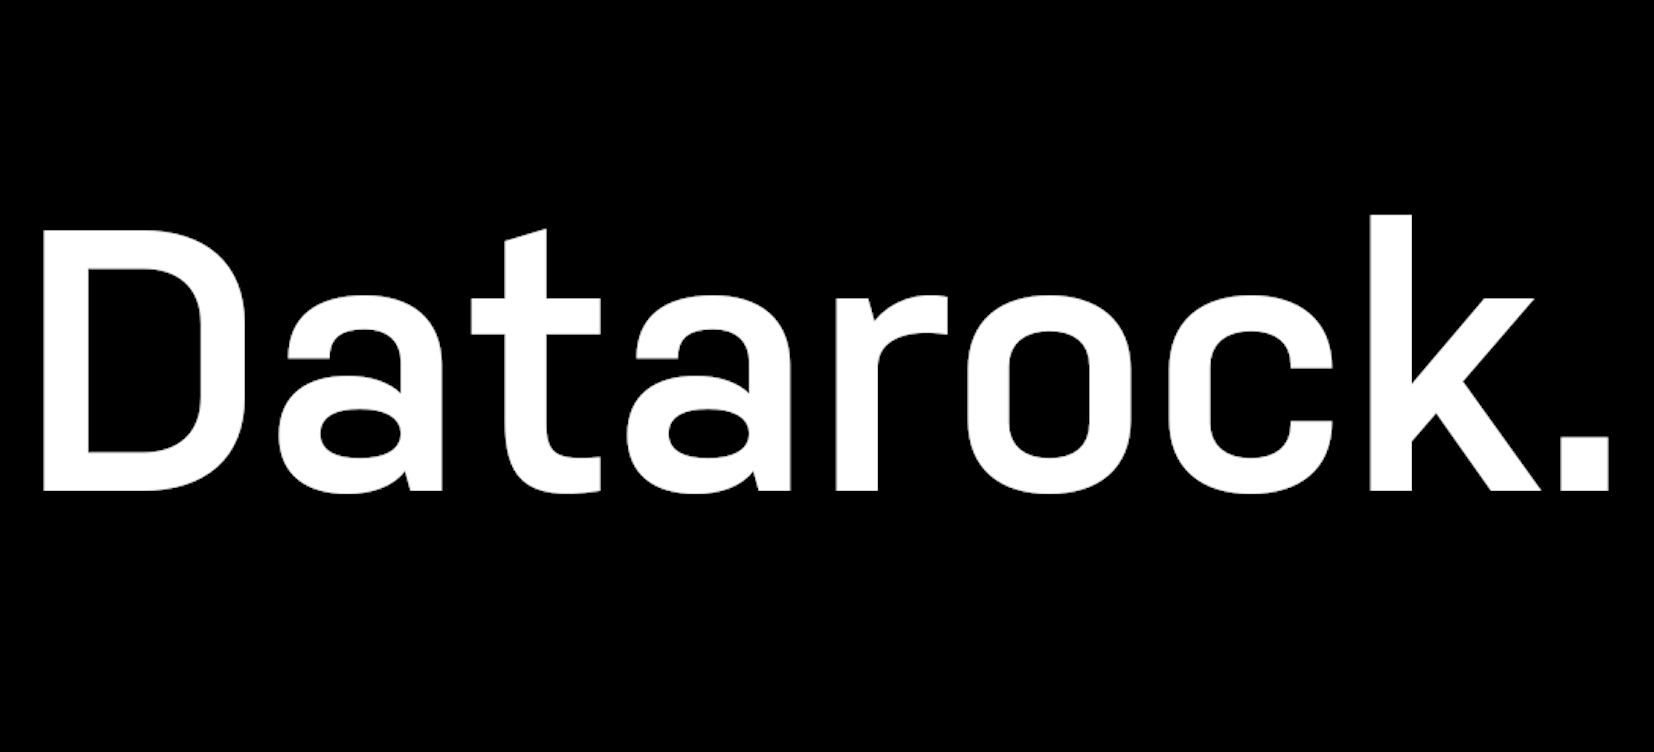

# __Introduction to Data Science NExUS__
### Part 2. Unsupervised Clustering Example



##### __Datarock 2022__
This is the second notebook of the NExUS Data Science session. Here we look at implementing the python basics covered in Notebook 1 - Python for Beginners into a machine learning workflow, 

#### __Notebook Contents__
Unsupervised Machine Learning Example
- EDA (Exploratory Data Analysis)
- Data Preprocessing
- ML Modelling
- Review Results

# Unsupervised Clustering
For the machine learning workflow we will apply an unsupervised learning (clustering) algorithm to some soil geochemistry data over the Hillside deposit in South Australia. The data has been sourced from [SARIG](https://map.sarig.sa.gov.au) and manipulated slightly for training purposes. We will be using the K-Means algorithm to find samples that share similar geochemical assay values and cluster them together.

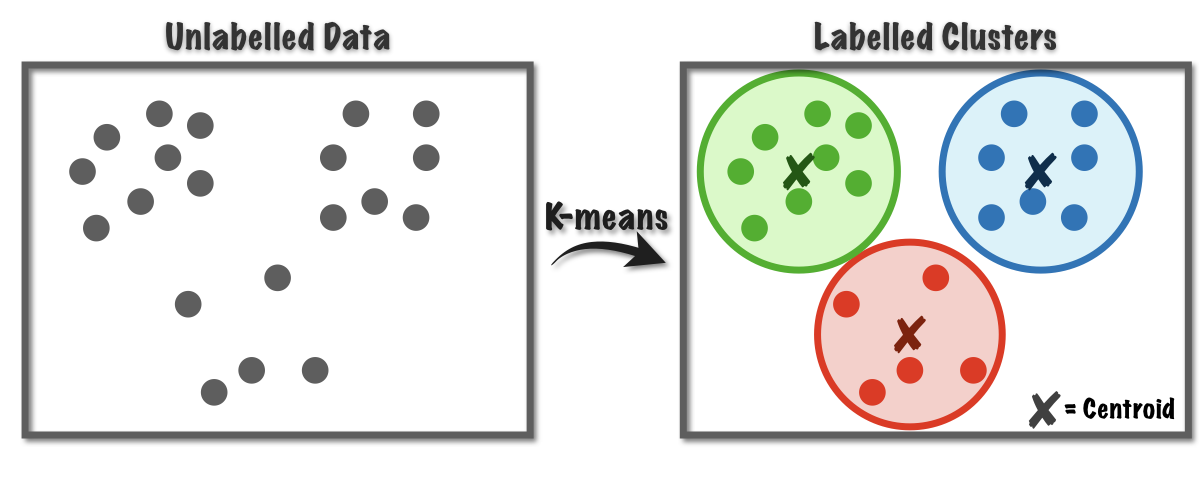

The K-Means algorithm works by the user selecting K amount of centroids that are placed randomly within the data space. The distance between these random centroids and all other data points are then calculated, with each data point being assigned to its nearest centroid. For data points assigned the same cluster centroid, the average location is calculated within this group and this becomes the new centroid. This process is repeated until no more changes are made to the centroids.

[K-Means Clustering Example](https://siliconvalley.basisindependent.com/2022/03/09/week-2-clustering-and-image-segmentation/)

[K-Means 1](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)

[K-means 2](https://ai.plainenglish.io/understanding-k-means-clustering-hands-on-visual-approach-c2dc46f0ed18)

For this notebook we will require a few python libraries, we will then use pandas to read in a csv file that is stored in a github repository.

In [ ]:
#Libraries for data loading and manipulation
import pandas as pd
import numpy as np

#Libraries for visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Libraries for Machine Learning
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

In [ ]:
#URL to the data
url = 'https://raw.githubusercontent.com/jack-tuna/Jupyter-Workings/master/DATAROCK_NExUS_Hillside.csv'

#Using pandas to read the data into our notebook
df = pd.read_csv(url)
df

Note that we are using a function in pandas named ___read_csv___ to load the data into a variable called ___df___. This is short for dataframe and is a standard naming convention in python.

We can see above that the data has been successfully loaded in and contains the sample number, longitude, latitude and elements Ca, Cu, K, Mn, & Ti. You may notice that the last line in the above cell did not use the ___print(df)___ function but still shows an output. Notebooks are intelligent enough to print the last line of code in a cell which can make our coding a little easier as well.

### EDA (Exploratory Data Analysis)
After loading the data, the first and arguably most crucial step in the machine learning work flow is the EDA (Exploratory Data Analysis). This steps gives us an idea of what the data looks like, how its distributed, and if there are there any missing data or outliters etc. In the next cell we call a function called _info()_ that will give us an idea of how big our dataset is and if there are any missing data.

In [ ]:
# Getting information about our dataframe
df.info()

From the output we can see that we have 1777 non-null rows for each column (meaning no missing data) and that all columns are data type float or int. To get some first order statistics on each column we can use the _describe_ function as seen below.

In [ ]:
# Getting first order statistics for each column
df.describe()

Here we can get a better idea of how our data is distributed. One thing to check for with geochemical data is negative or zero values but thankfully this dataset is clean and does not require any fixing. Another important EDA step is to see where our data is spatially. We can use the longitude and latitude information in the dataframe to plot this data geographically. In the below cell we use the Plotly library to plot the data.

In [ ]:
# Creating our figure
fig = px.scatter_mapbox(df, lat="LATITUDE", lon="LONGITUDE", 
                        hover_name="SAMPLE_NO", size=np.ones(len(df)), 
                        size_max=5, color_discrete_sequence=["black"], 
                        zoom=15, opacity=1)

# Updating some figure parameters
fig.update_layout(
    margin={"r":25,"t":25,"l":25,"b":25},
    width=750,
    height=750,           
    mapbox_style="white-bg",
    mapbox_layers=[{
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": ["https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"]}
      ])

#Plotting the figure
fig.show()

We can see that the samples are from a regularly spaced geochemical survey on the east coast of Yorke Peninsula. We can also view the data in 2D scatter plots to better understand them, but first lets make a list all the elements. 

In [ ]:
#Create a list of the elements
feature_names = ['Ca_ppm', 'Cu_ppm', 'K_ppm', 'Mn_ppm', 'Ti_ppm']

We have called the list variable _feature_names_ because each of the elements will be features in our ML workflow. The term feature (sometimes variable) is definied as an individual property that can be used for analysis, such as a geochemical element in our case.  

In [ ]:
# Plot a scatter matrix of all features
fig = px.scatter_matrix(df, dimensions=feature_names)
fig.update_traces(marker=dict(size=6,line=dict(width=0.5,color='black')))
fig.update_layout(width=1000, height=1000)
fig.show()

Scatter plots are one way of showing us how both the distribution and relationships between features look. If we are happy that the data is clean enough to use and is truly reflective of what we are trying to model we can move onto the preprocessing stage.

## Preprocessing
Preprocessing steps are often required to optimise the data for the modelling type. Many processes in machine learning make assumptions about the data and how it is distributed. In the case of the K-Means algorithm, it works best if the data is normally distributed (bell curve). In the next couple of cells we will assess the normality of the data and apply a log transformation if neccessary. 

In [ ]:
#Print the feature names so we remember what is available
print(feature_names)

In [ ]:
#Select element to assess
element = 'Ca_ppm'

#Make subplots to plot histograms
fig = make_subplots(rows=1, cols=2, subplot_titles=("Original Data", "Log Transform"))

#Add original histogram to column 1 and add log transformed one to column 2
fig.add_trace(go.Histogram(x=df[element], nbinsx=100),row=1, col=1)
fig.add_trace(go.Histogram(x=np.log(df[element]), nbinsx=100), row=1, col=2)

fig.update_layout(height=500, width=800, title_text=f"Histograms of {element}", showlegend=False)
fig.show()

Cycle through each element and compare the data distributions, and then in the list below, add the element if you think it should be transformed uysing a logarithmic transform.

In [ ]:
#Create a list to transform
list_to_transform = ['Ca_ppm', 'Cu_ppm', 'K_ppm', 'Mn_ppm']

#Create a copy
dfc = df.copy()

#Apply the log transform
dfc[list_to_transform] = np.log(df[list_to_transform])

Another important and regularly used preprocessing step in machine learning is data scaling or normalising. The distance between points is very important to ML models and scaling the data removes any unwanted bias. In the cell below we use a python function to scale each feature in our dataset to 0-1.

In [ ]:
#Define a function
def scale_data(X):

  #Scale the data to 0-1
  X_sc = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  
  return X_sc

#Use the above function and describe the data
X = scale_data(dfc[feature_names])
X.describe()

We can now see that each element has a minimum value of 0 and a maximum value of 1. The data is now ready to be modelled.

## Modelling

In the next few cells we will implement the K-Means unsupervised model. We will use the K-Means algorithm that was imported from [Sci-Kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). No algorithms are a silver bullet and all require some human input parameters. For K-Means clustering the biggest parameter is K, which is the number of clusters we want to get. There are several approaches to help us determine the optimal value for K, but in this example we will use the [Silhouette Score](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c). The silhouette score basically tells us how close all the points are to their own cluster with respect to the other clusters. Using a ___'For'___ loop, we can check the silhouette score a number of different K values.  

In [ ]:
# Set an empty list to append to
silhouette_scores = []

# Create a range of values from 3-12 using a python built-in range function
K_range = range(3,12)

# Loop through for each cluster
for K in K_range:

    # Create a KMeans model with the current cluster number
    kmeans = KMeans(n_clusters=K)

    # Fit the KMeans model to the data and get the labels
    labels = kmeans.fit(X).labels_

    # Extract the silhouette score from the current cluster 
    silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean', random_state=42)
    
    # Append the score to the list
    silhouette_scores.append(silhouette_score)

# Create a dataframe of scores
df0 = pd.DataFrame({'Clusters': K_range, 'Silhouette Score': silhouette_scores})

# Plot the scores
fig = px.line(df0, x='Clusters', y='Silhouette Score')
fig.update_traces(mode='lines+markers')
fig.update_layout(width=700,height=600)
fig.show()

The higher the silhouette score, the more optimal that number of clusters. We can see that a KMeans model with 6-7 clusters is best for our data. In the next cell we can recreate the K-Means model with a cluster number of 7 and assess the results.

In [ ]:
# Set the number of clusters
K = 7

# Create the algorithm
kmeans_model = KMeans(n_clusters=K, random_state=0)

#Fit the algorithm to the data, creating the model
kmeans_model.fit(X)

#Add a column to our data frame with the cluster labels, with the data type string
df['clusters'] = kmeans_model.labels_.astype(str)

Now that we've fit the model to our data and got the cluster labels, we can plot the data up and see how our clusters compare. In the cell below we plot a similar scatter matrix to what we had in the EDA section, except this time coloured by cluster label.

In [ ]:
#Plotting scatter matrix coloured by cluster label
fig = px.scatter_matrix(df, color='clusters', dimensions=feature_names, color_discrete_sequence=px.colors.qualitative.Light24)
fig.update_traces(marker=dict(size=6,line=dict(width=0.5,color='black')))
fig.update_layout(width=1000, height=1000)
fig.show()

This shows us how the K-Means model is grouping the data together. Finally, we can also plot the clusters spatially.

In [ ]:
# Creating our figure
fig = px.scatter_mapbox(df, lat="LATITUDE", lon="LONGITUDE", color = 'clusters', 
                        hover_name="SAMPLE_NO", color_discrete_sequence=px.colors.qualitative.Light24,  
                        size=np.ones(len(df)), size_max=8, zoom=15, height=300, opacity=1)

# Updating some figure parameters
fig.update_layout(
    margin={"r":25,"t":25,"l":25,"b":25},
    width=750,
    height=750,           
    mapbox_style="white-bg",
    mapbox_layers=[{
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": ["https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"]}
      ])

# Plotting the figures
fig.show()

Here we see some distinct patterns shown in the clusters and noticeably the NW-SE trend of cluster 3 and 5. Referring back to the scatter matrix, we can see that these two clusters contain the highest amount of copper out of the 7 clusters 🤔🤔🤔. What we have done here is created a way to visualise 5 different elements in a single map using multivariate statistics. This methodology provides a different way of looking and thinking about how to analyse data more quickly than traditional methods, allowing the geologists more time to do geology. 